# Регрессия - пора творить!

Если вы дошли до этой практики и выполнили все предыдущие - вау! Аплодисменты вам!

<p align="center"><img src="https://s3.wi-fi.ru/cp3o/zqEeEKCkhPUnnwD3dHmuEmQq?response-content-type=image%2Fjpeg" width=500/></p>



Тем не менее, не время расслабляться! На этот раз, мы не будем рассказывать вам новый материал - лишь дадим пару напутствий и пожелаем успехов и сил!

В этот раз вам предлагается разработать модель предсказания цены домов по набору данных Boston Houses Pricing. Мы его уже немного пощупали в прошлой практике, но в этой вам предстоит сделать всё самостоятельно и на полных данных!

Что надо будет сделать:
- Загрузить данные
- Посмотреть и размер, и примеры данных
- Проверить количество пропусков в данных
    - Убедиться, что пропусков в данных нет и можно строить **baseline**
- Делим данные на train и test 
    - Делаем это один раз! Все дальнейшие модификации и улучшения должны делаться на основе единственного разделения!
    - И не забудьте зафиксировать сид! Переменную `RANDOM_SEED` мы даём ниже
- Создаем baseline модель, снимаем метрики на тестовой выборке
- Производим анализ данных, готовим план по очистке и предобработке данных
- Создаем функцию очистки
- Производим очистку train и test выборок -> обучаем модель с очищенными данными
    - Снимаем метрики и так мы оцениваем влияние очистки данных на обучение
- Создаем класс предобработки данных
- Производим предобработку очищенных данных -> обучаем модель
    - Снимаем метрики и так мы оцениваем влияние предобработки данных на обучение

А дальше можете пофантазировать, почитать интернет и посмотреть, как улучшить метрики! 

**Ваша цель - достигнуть наилучших показателей!**

Вот вам пара идей по интересной организации предобработке:
- По признаку `CRIM` создать признак `is_CRIM`, который будет равен 1, если `CRIM` не равен 0 и 0, если `CRIM` равен нулю
- Сделать обучение модели [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html), посмотреть, какие признаки имеют веса близкие к 0 и убрать их из обучения как незначимые
- Оставить только признаки с высокой корреляцией с целевой переменной
- Посмотреть, какие переменные коррелирцют между собой и оставить только единственные из пар коррелирующих
- Посмотреть, в каких примерах данных модель ошибается сильнее всего (отсортировать записи из теста по величине ошибки) и проанализировать, есть ли какая-то зависимость или шум
- Комбинировать разные подходы в зависимости от того, помогает это предсказаниям или нет

Ещё большим плюсом будет, если вы покажете, как влияет каждый этап предобработки на результаты обучения!

In [283]:
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

TEXT_COLOR = 'white'

matplotlib.rcParams['figure.figsize'] = (15, 10)
matplotlib.rcParams['text.color'] = TEXT_COLOR
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['lines.markersize'] = 15
matplotlib.rcParams['axes.labelcolor'] = TEXT_COLOR
matplotlib.rcParams['xtick.color'] = TEXT_COLOR
matplotlib.rcParams['ytick.color'] = TEXT_COLOR

sns.set_style('darkgrid')

# Зафиксируем состояние случайных чисел
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

Что мы ждем от вас? 

Готовый ноутбук с таким же названием, в котором будут обязательные пункты с выводами по анализу данных и анализу поведения модели, а также дополнительные пункты по вашим размышлениям и процессу улучшения модели.

Успехов вам, мы в вас верим и уверены, что вы точно справитесь!

<p align="center"><img src="https://raw.githubusercontent.com/kail4ek/ml_edu/master/assets/cat-computer-peek-out-36960208.jpg" width=600/></p>

In [284]:
df_src = pd.read_csv('boston.csv')

In [285]:
df_src.shape

(506, 14)

In [286]:
df_src.head(10)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222.0,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311.0,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311.0,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311.0,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311.0,15.2,386.71,17.10,18.9


In [287]:
df_src.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [288]:
df_src.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

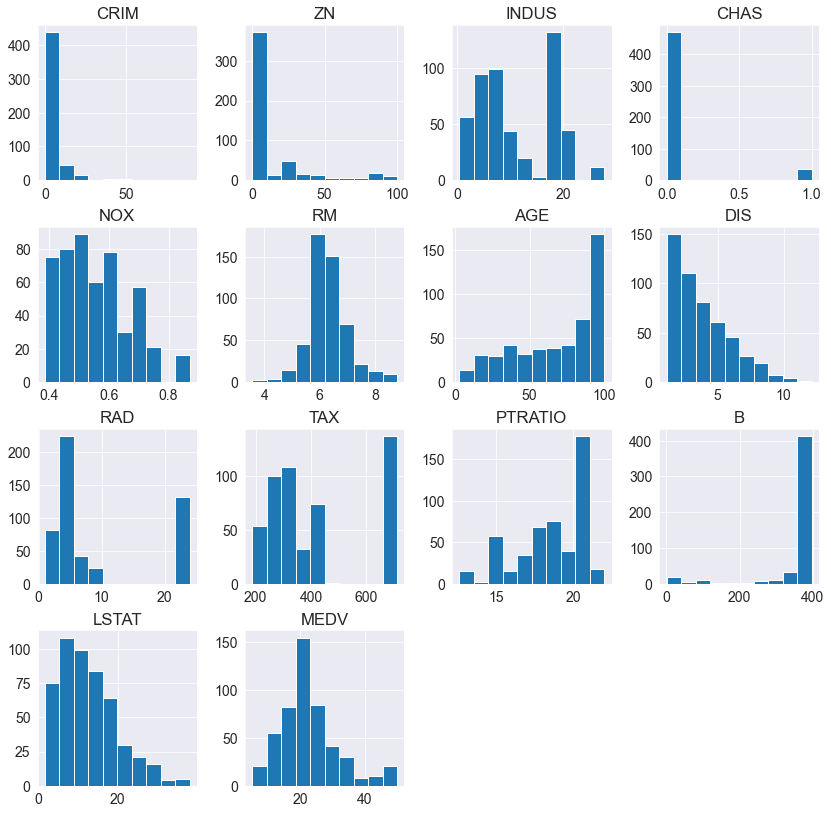

In [289]:
#посмотрим распределение всех столбцов
df_src.hist(figsize=(14,14))
plt.show()

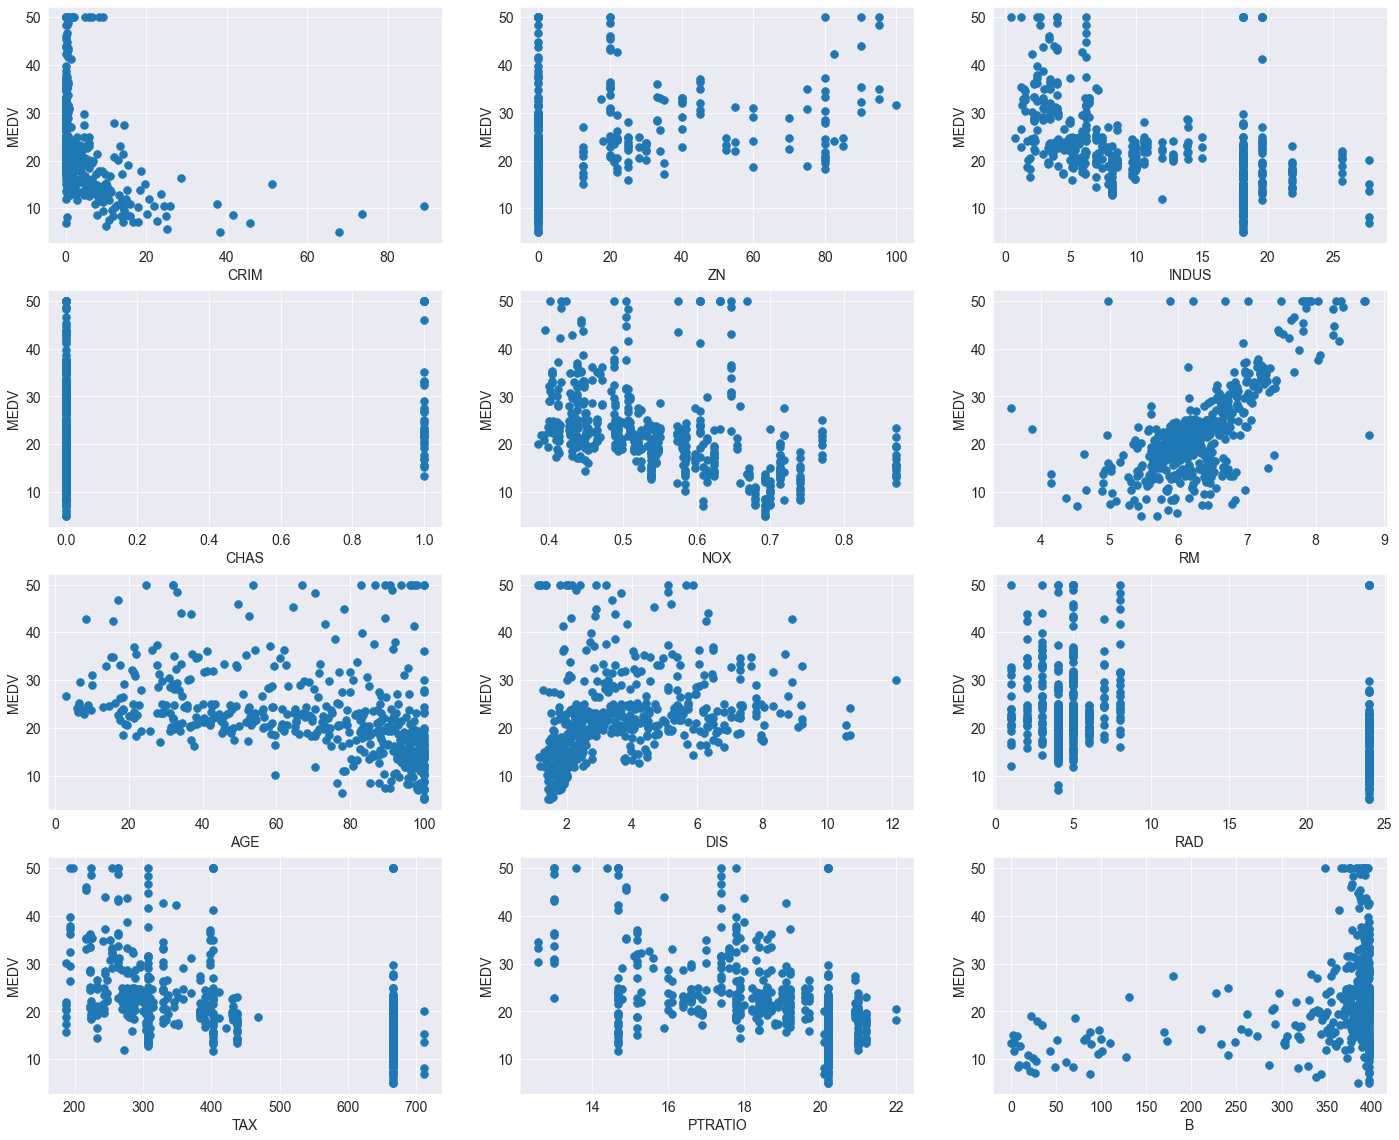

In [290]:
#Посмотрим связь MEDV и остальных характеристик
plt.figure(figsize=(24,20))

for var , i in zip(df_src.columns,np.arange(1,len(df_src.columns)-1)):
    plt.subplot(4,3,i)
    plt.scatter(df_src[var], df_src.MEDV, marker='.')
    plt.xlabel(f"{var.upper()}")
    plt.ylabel("MEDV")

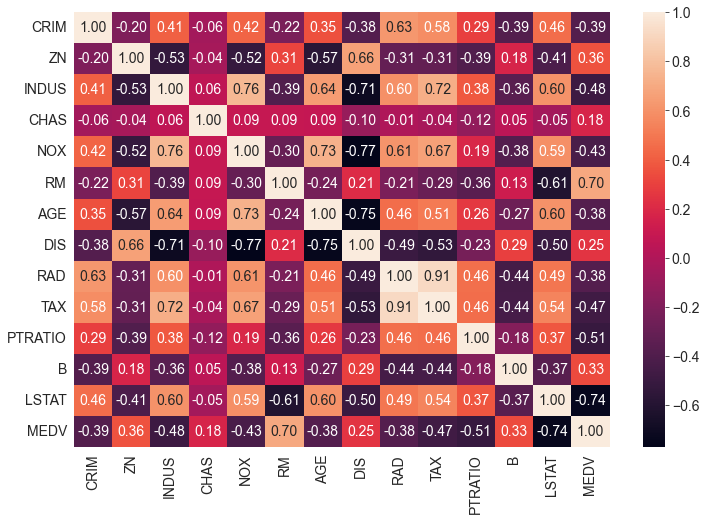

In [291]:
plt.figure(figsize = (12,8))
sns.heatmap(df_src.corr(),annot=True,fmt='.2f')
plt.show()

In [292]:
def cleaning(df):
    mask =  (df.loc[:,'RM'] < 4) | (df.loc[:,'MEDV'] == 50) | (df.loc[:,'PTRATIO'] == 20.2) | ((df.loc[:,'MEDV'] < 30) & (df.loc[:,'RM'] > 8))
    df = df[~mask]
    for i in np.arange(df.shape[0]):
        if df.loc[df.index[i], 'CRIM'] < 0.1:
            df.loc[df.index[i], 'is CRIM'] = 0  
        else:  df.loc[df.index[i], 'is CRIM'] = 1
    df['DIS_log'] = np.log(df['DIS'])
    df = df.drop('DIS',1)
    df['LSTAT_poly_2'] = df['LSTAT']**2
    return df

def fitDf(df):
    scaler = MinMaxScaler()
    df = cleaning(df)
    scaler = scaler.fit(df)
    return scaler

def transformDf(scaler, df):
    df = cleaning(df)
    index = df.index
    column = df.columns
    df=scaler.transform(df)
    df=pd.DataFrame(data=df,index=index,columns=column)
    return df

In [300]:
df_train_data, df_test_data = train_test_split(df_src,test_size=0.3,random_state=RANDOM_SEED)
scaler = fitDf(df_train_data)
df_train = transformDf(scaler, df_train_data)
df_test = transformDf(scaler, df_test_data)
train = df_train.copy()
test = df_test.copy()
model = LinearRegression()
train_data = train.pop('MEDV')
model.fit(train, train_data)
y_true = test.pop('MEDV')
y_pred = model.predict(test)


C:\Users\слава\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\Users\слава\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:

In [301]:
R2 = r2_score(y_true, y_pred)
MAE = mean_absolute_error(y_true, y_pred)
MSE = mean_squared_error(y_true, y_pred)
RMSE = np.sqrt(MSE)
print(f"R2 = {R2}, MAE = {MAE}, MSE = {MSE}, RMSE = {RMSE}")

R2 = 0.8390655482211383, MAE = 0.05281945292584616, MSE = 0.004727887548759592, RMSE = 0.06875963604295468


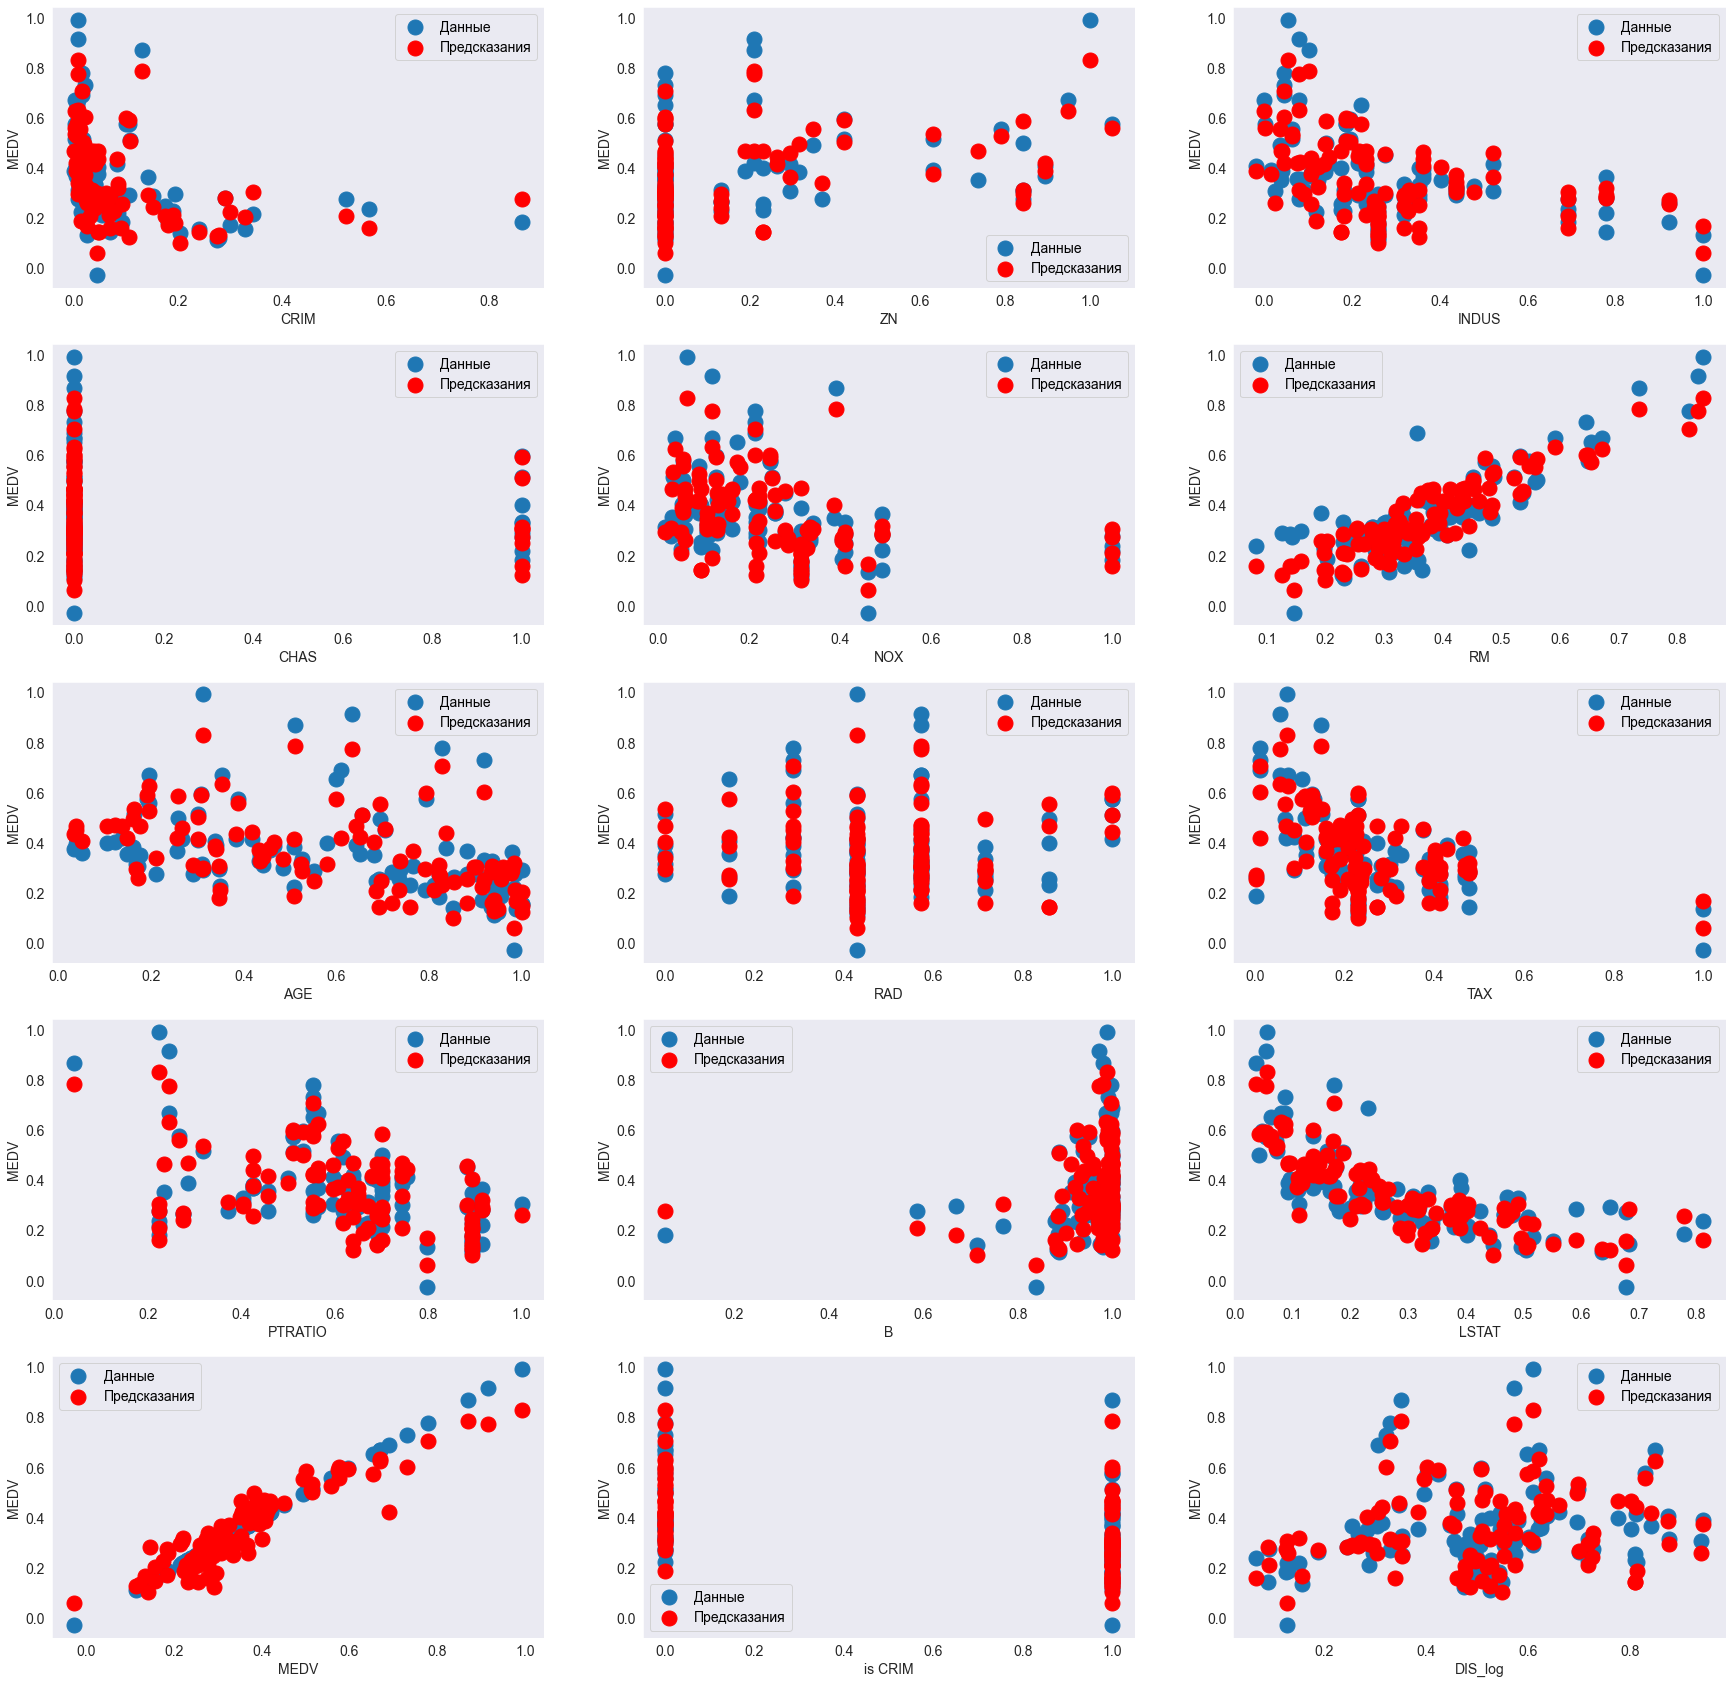

In [302]:
#Посмотрим на предсказания
plt.figure(figsize=(30,30))
for col , i in zip(df_test.columns.values,range(1, len(df_test.columns))):
    plt.subplot(5,3,i)
    plt.scatter(x = col, y='MEDV', data=df_test,label='Данные')
    plt.scatter(x = df_test[col], y = y_pred, c='r', label='Предсказания')
    plt.grid()
    plt.xlabel(f"{col}")
    plt.ylabel("MEDV")
    plt.legend(labelcolor = 'black')
plt.show()

In [303]:
scaler = fitDf(df_train_data)
df_train = transformDf(scaler, df_train_data)
df_test = transformDf(scaler, df_test_data)
train = df_train.copy()
test = df_test.copy()
model = Ridge()
train_data = train.pop('MEDV')
model.fit(train, train_data)
y_true = test.pop('MEDV')
y_pred = model.predict(test)


C:\Users\слава\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\Users\слава\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:

In [304]:
R2 = r2_score(y_true, y_pred)
MAE = mean_absolute_error(y_true, y_pred)
MSE = mean_squared_error(y_true, y_pred)
RMSE = np.sqrt(MSE)
print(f"R2 = {R2}, MAE = {MAE}, MSE = {MSE}, RMSE = {RMSE}")

R2 = 0.8319839550671244, MAE = 0.052274804366571934, MSE = 0.004935928622179029, RMSE = 0.0702561643002166


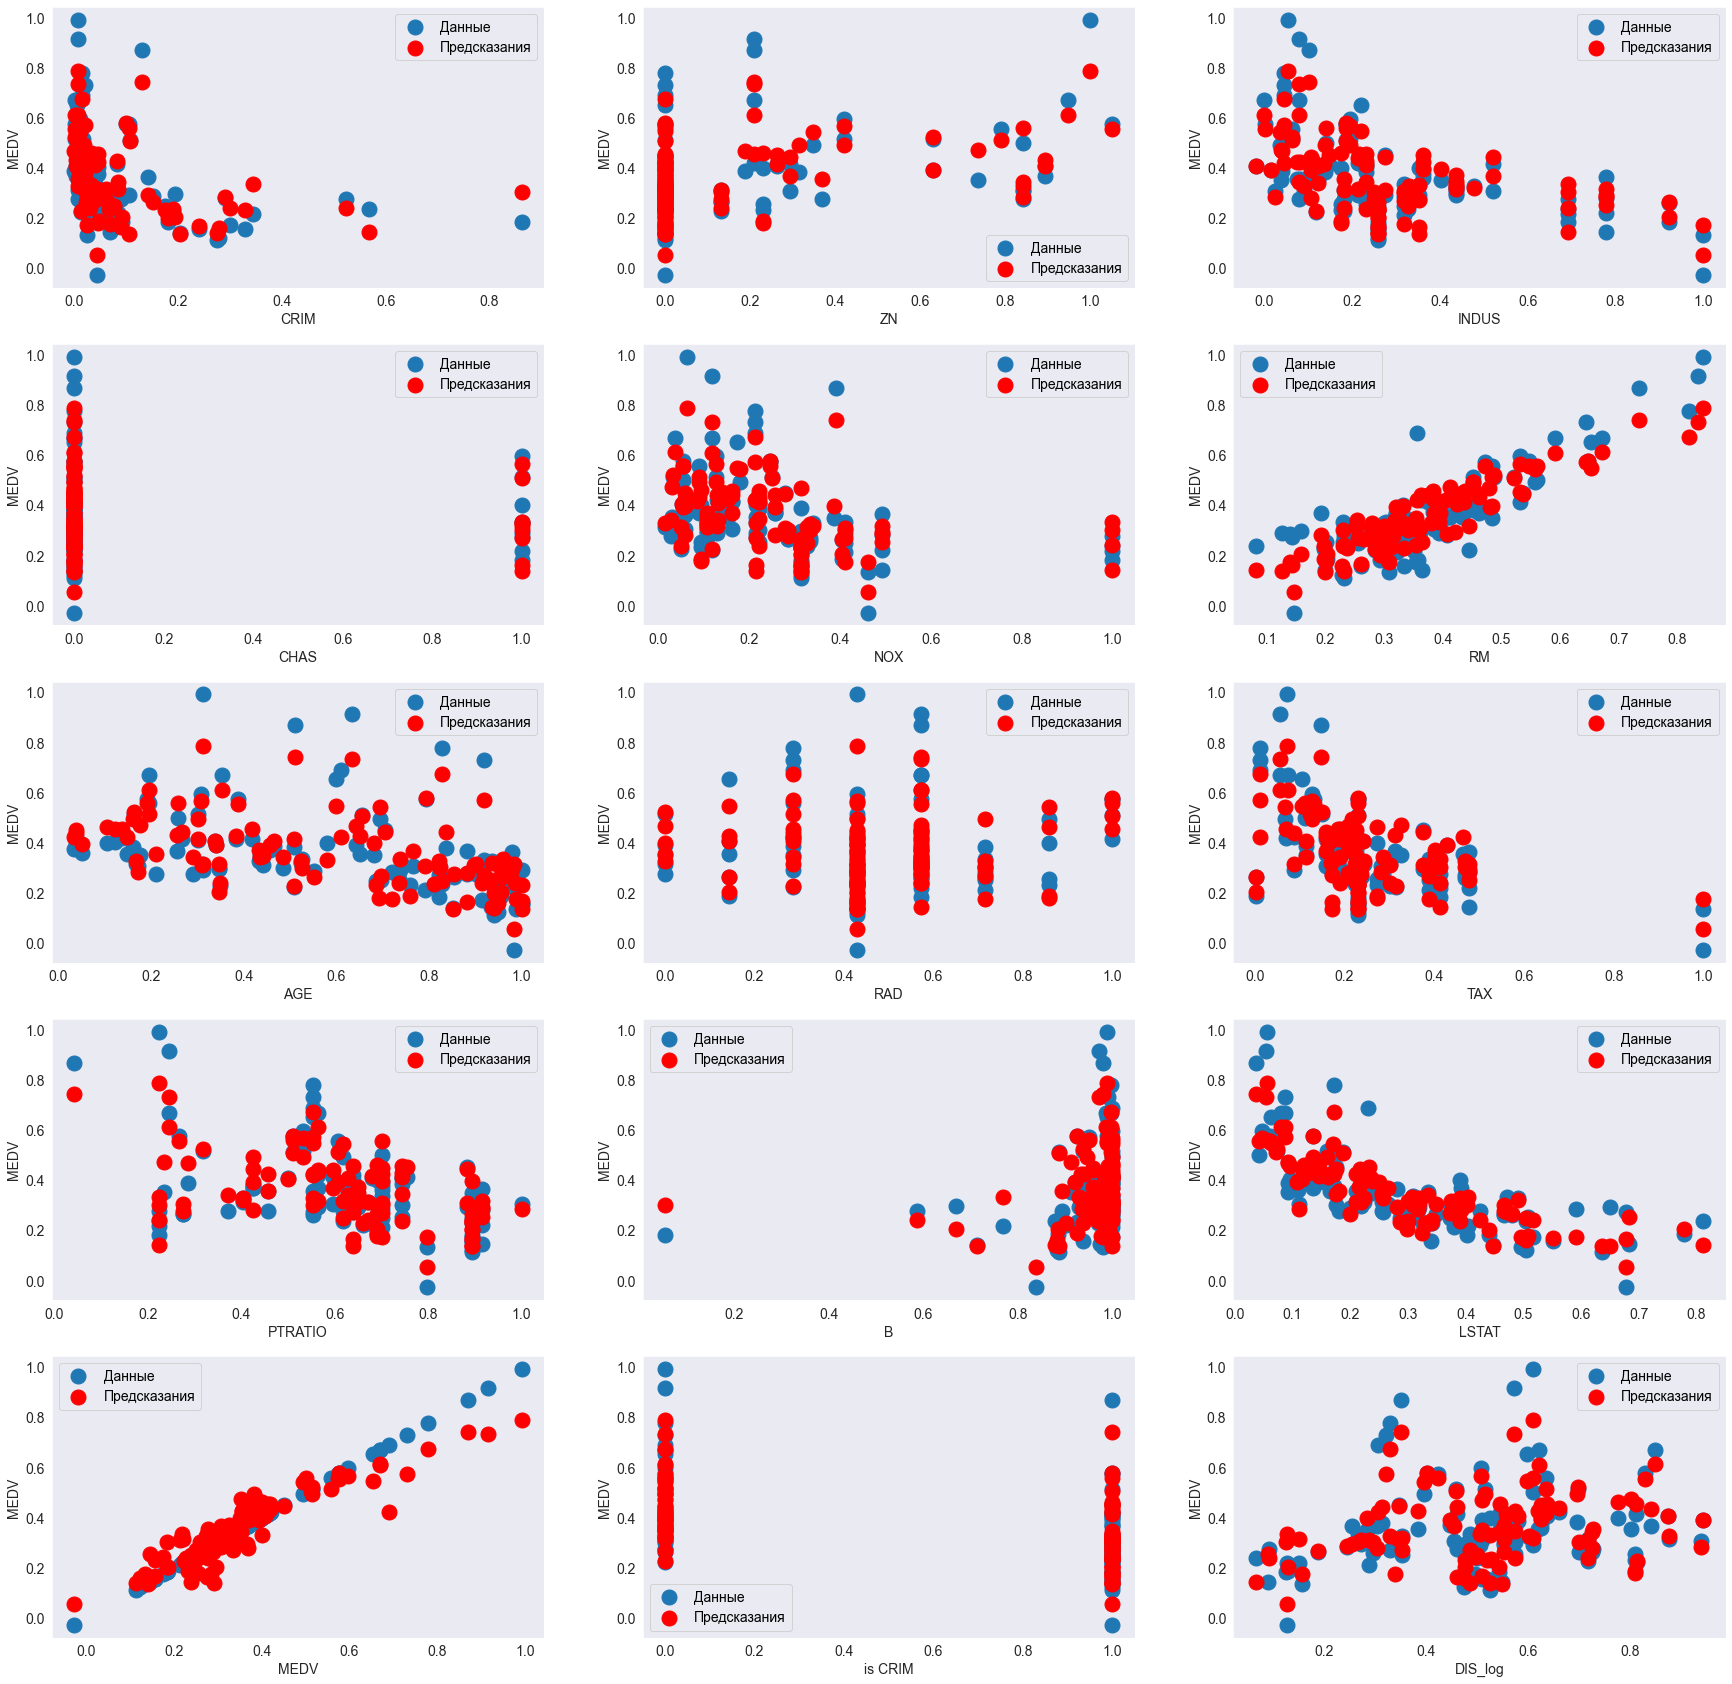

In [305]:
#Посмотрим на предсказания
plt.figure(figsize=(30,30))
for col , i in zip(df_test.columns.values,range(1, len(df_test.columns))):
    plt.subplot(5,3,i)
    plt.scatter(x = col, y='MEDV', data=df_test,label='Данные')
    plt.scatter(x = df_test[col], y = y_pred, c='r', label='Предсказания')
    plt.grid()
    plt.xlabel(f"{col}")
    plt.ylabel("MEDV")
    plt.legend(labelcolor = 'black')
plt.show()

##### Показатели при LinearRegression():
R2 = 0.8390655482211383, 
MAE = 0.05281945292584616, 
MSE = 0.004727887548759592, 
RMSE = 0.06875963604295468

##### Показатели при Ridge():
R2 = 0.8319839550671244, 
MAE = 0.052274804366571934, 
MSE = 0.004935928622179029, 
RMSE = 0.0702561643002166

Обе модели показывают хорошие показатели, но при этом по RMSE модель Ridge показала немного хуже результат, чем линейная регрессия. При этом видно, что значение ошибки достаточно мало в обоих случаях, поэтому можно сделать вывод, что обучение прошло успешно.